In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import numpy as np
import ase 
from ase.io import read
import json  
from ase.units import Hartree

In [3]:
torch.set_default_dtype(torch.float64) # set default dtype of torch to avoid numerical errors 

In [4]:
device = "cpu"

# Instantiate the Molecule Dataset 

In [5]:
from mlelec.data.dataset import MoleculeDataset

/home/suman/miniconda3/envs/qm7/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [6]:
molecule_data = MoleculeDataset(
    mol_name = "qm7",
    use_precomputed=True,
    path= "examples/data/qm7",
    aux_path="examples/data/qm7/sto-3g",
    frame_slice=slice(0, 1000),
    device=device,
    aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment", "polarisability"],
)

Loading structures
examples/data/qm7/sto-3g/fock.hickle
examples/data/qm7/sto-3g/dipole_moment.hickle
examples/data/qm7/sto-3g/polarisability.hickle


### Create the ML dataset from the molecular data 

In [7]:
from mlelec.data.dataset import MLDataset

In [8]:
ml_data = MLDataset(
    molecule_data=molecule_data,
    device=device,
    model_strategy="coupled",
    shuffle=True, 
    shuffle_seed=1234,
)

In [9]:
ml_data._split_indices(train_frac=0.8, val_frac=0.0, test_frac=0.2)

In [10]:
from mlelec.features.acdc import compute_features_for_target
from mlelec.data.dataset import get_dataloader

In [17]:
ml_data.target.tensor[0].shape

torch.Size([9, 9])

In [11]:
hypers = {
            "cutoff": 3.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }
hypers_pair = {
            "cutoff": 4.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

ml_data._set_features(compute_features_for_target(ml_data, device = device, hypers = hypers, hypers_pair = hypers_pair))

In [12]:
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="blocks", batch_size=50)

In [19]:
import metatensor
from metatensor import Labels

# Helper function to drop blocks in the train, validation and test subset that have zero samples due to splitting of the dataset

def drop_zero_blocks(train_tensor, val_tensor, test_tensor):
    for i1,b1 in train_tensor.items():
        if b1.values.shape[0] == 0:
            train_tensor = metatensor.drop_blocks(train_tensor, Labels(i1.names, i1.values.reshape(1,-1)))
            
    for i2,b2 in val_tensor.items():
        if b2.values.shape[0] == 0:
            val_tensor = metatensor.drop_blocks(val_tensor, Labels(i2.names, i2.values.reshape(1,-1)))
            
    for i3,b3 in test_tensor.items():
        if b3.values.shape[0] == 0:
            test_tensor = metatensor.drop_blocks(test_tensor, Labels(i3.names, i3.values.reshape(1,-1)))
            
    return train_tensor, val_tensor, test_tensor

In [20]:
ml_data.target_train, ml_data.target_test = drop_zero_blocks(ml_data.target_train, ml_data.target_test)

In [21]:
ml_data.feat_train, ml_data.feat_test = drop_zero_blocks(ml_data.feat_train, ml_data.feat_test)

# RidgeCV Model

In [22]:
from src.mlelec.models.linear import LinearTargetModel

## Fitting a RidgeCV model

In [23]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = device)

In [25]:
pred_ridges, ridges = model.fit_ridge_analytical(alpha=np.logspace(-8, 3, 12), cv=3, set_bias=False)

## Prediction and Calculating train and test errors

In [26]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, _to_matrix
    
uncoupled = _to_uncoupled_basis(pred_ridges,  device=model.device) # Convert the coupled blocks to uncoupled

# Recover the predicted matrices for the training set 
fock_predictions_train = _to_matrix(
    uncoupled,
    ml_data.train_frames,
    ml_data.train_idx,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

In [27]:
pred_test = model.predict_ridge_analytical(ml_data.target_test, ml_data.feat_test)

In [28]:
test_uncoupled = _to_uncoupled_basis(pred_test,  device=model.device) # Convert the coupled blocks to uncoupled
fock_predictions_test = _to_matrix(
test_uncoupled,
    ml_data.test_frames,
    ml_data.test_idx,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

In [29]:
from IPython.utils import io
import mlelec.metrics as mlmetrics
from src.mlelec.utils.dipole_utils import *

Using PyTorch backend.


### RMSE on Full Hamiltonian

In [30]:
from mlelec.utils.twocenter_utils import fix_orbital_order
from ase.units import Hartree
import matplotlib.pyplot as plt

In [31]:
error_full_train = np.sqrt(mlmetrics.L2_loss(fock_predictions_train, [ml_data.target.tensor[i] for i in ml_data.train_idx])
                     /len(ml_data.train_idx)) * Hartree
error_full = np.sqrt(mlmetrics.L2_loss(fock_predictions_test, [ml_data.target.tensor[i] for i in ml_data.test_idx])
                     /len(ml_data.test_idx)) * Hartree
print("Train RMSE for full Hamiltonian in eV: ", error_full_train.item())
print("Test RMSE for full Hamiltonian in eV: ", error_full.item())

Train RMSE for full Hamiltonian in eV:  0.11529495412398082
Test RMSE for full Hamiltonian in eV:  0.11812477139543373


Text(0.5, 1.0, 'parity plot for Hamiltonian')

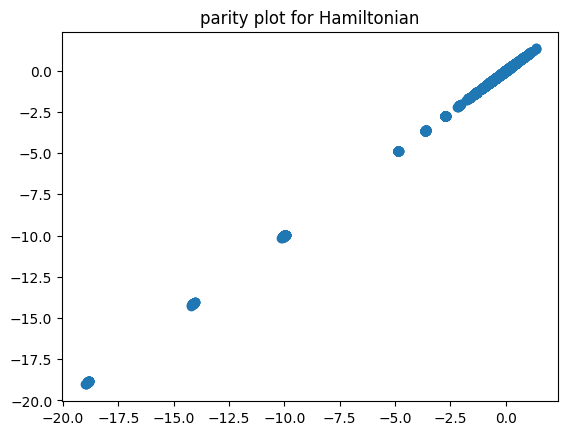

In [25]:
# plt.scatter(torch.cat([ml_data.target.tensor[i].flatten() for i in ml_data.test_idx]), 
#             torch.cat([f.flatten() for f in fock_predictions_test]))

### RMSE on MO energies

In [27]:
## To enable comparisons between molecules of different sizes in the QM7 dataset, all  error  estimates 
## are  computed  based on the quantity divided  by  the  number  of  atoms contained within  a  given  molecule.

In [32]:
eva = compute_eigvals(ml_data, [ml_data.target.tensor[i] for i in ml_data.train_idx], ml_data.train_idx)
pred_eva =  compute_eigvals(ml_data, fock_predictions_train, ml_data.train_idx)

print("Train RMSE on MO energies in eV:", (torch.sqrt(mlmetrics.mse_qm7(ml_data.train_frames, pred_eva, eva))).item()*Hartree)

Train RMSE on MO energies in eV: 0.22775075036145281


In [33]:
test_eva = compute_eigvals(ml_data, [ml_data.target.tensor[i] for i in ml_data.test_idx], ml_data.test_idx)
pred_test_eva =  compute_eigvals(ml_data, fock_predictions_test, ml_data.test_idx)

print("Test RMSE on MO energies in eV:", (torch.sqrt(mlmetrics.mse_qm7(ml_data.test_frames, pred_test_eva, test_eva))).item()*Hartree)

Test RMSE on MO energies in eV: 0.23197761972435804


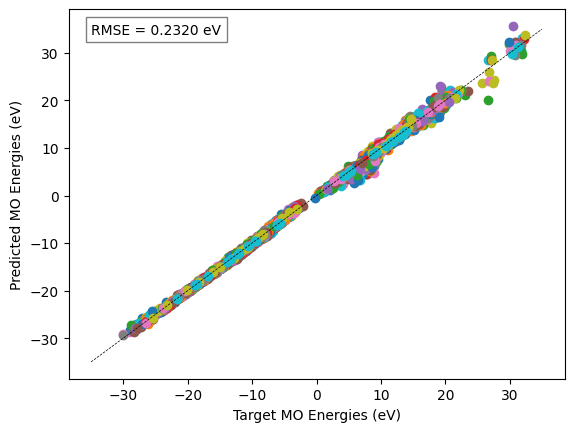

In [34]:
plt.figure()
for target, predicted in zip(test_eva, pred_test_eva):
    x = target.detach().numpy() * Hartree
    y = predicted.detach().numpy() * Hartree
    
    x = x[x>-100]
    y = y[y>-100]
    plt.scatter(x,y)
    
plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.text(-35, 34, f'RMSE = {(torch.sqrt(mlmetrics.mse_qm7(ml_data.test_frames, pred_test_eva, test_eva))).item()*Hartree:.4f} eV', fontsize = 10, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
plt.savefig("plot_polar/mse_eva_ridge.pdf", bbox_inches="tight")

### RMSE on Dipole moments

In [35]:
fock_predictions_train_unfix = unfix_orbital_order(
    fock_predictions_train,
    ml_data.train_frames,
    ml_data.molecule_data.aux_data["orbitals"],
)

with io.capture_output() as captured:
    
    dipole_predictions_train = compute_dipole_moment(
        ml_data.train_frames,
        fock_predictions_train_unfix,
        ml_data.molecule_data.aux_data["overlap"][ml_data.train_idx],
    )
    
error = mlmetrics.mse_qm7(ml_data.train_frames,
    dipole_predictions_train, torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][ml_data.train_idx].astype(np.float64))
)
print("Train RMSE on dipole in A.U.:", (torch.sqrt(error)).item())

Train RMSE on dipole in A.U.: 0.022413771660376766


In [36]:
with io.capture_output() as captured:
    # convert prediction back to pyscf order
    fock_predictions_test_unfix = unfix_orbital_order(
        fock_predictions_test,
        ml_data.test_frames,
        ml_data.molecule_data.aux_data["orbitals"],
    )

    dipole_predictions_test = compute_dipole_moment(
        ml_data.test_frames,
        fock_predictions_test_unfix,
        ml_data.molecule_data.aux_data["overlap"][ml_data.test_idx],
    )

error = mlmetrics.mse_qm7(ml_data.test_frames,
    dipole_predictions_test, torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx].astype(np.float64))
)
print("Test RMSE on dipole in A.U.:", (torch.sqrt(error)).item())

Test RMSE on dipole in A.U.: 0.024332483711520653


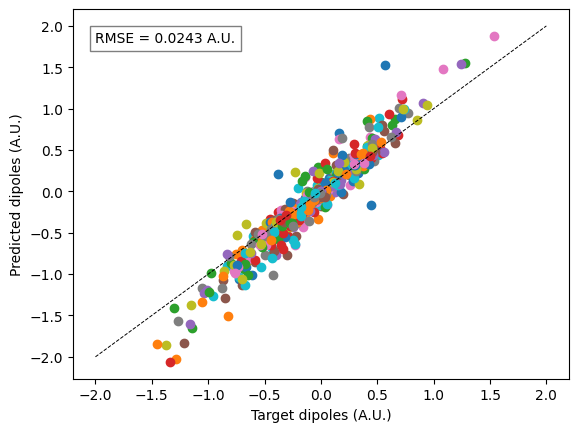

In [37]:
plt.figure()
for predicted, target in zip(dipole_predictions_test.detach().numpy(), ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x,y)
# plt.plot([-2,1.5], [-2,1.5], linestyle='--', color='black', linewidth=0.5)
   
plt.plot([-2,2], [-2,2], linestyle='--', color='black', linewidth=0.7)
plt.xlabel('Target dipoles (A.U.)')
plt.ylabel('Predicted dipoles (A.U.)')
plt.text(-2, 1.8, f'RMSE = {(torch.sqrt(error)).item():.4f} A.U.', fontsize = 10, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
plt.savefig("plot_polar/mse_dipole_ridge.pdf", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

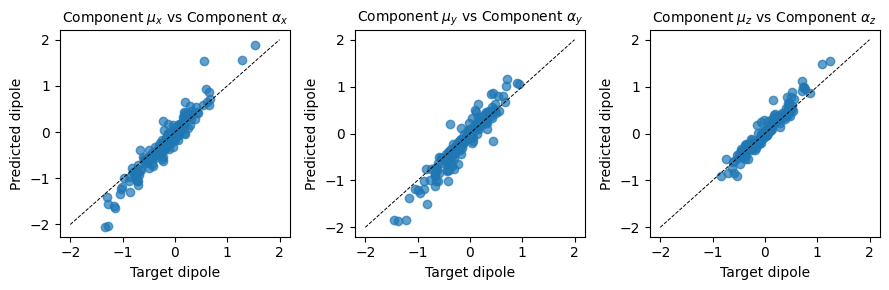

In [38]:
plt.figure()
fig, axs = plt.subplots(1,3, figsize=(9,3))
for i in range(3):
    ax = axs[i]
    l = ["x", "y", "z"]
    ax.scatter(ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx][:, i],
               dipole_predictions_test.detach().numpy()[:, i], alpha=0.7)
    ax.plot([-2,2], [-2,2], linestyle='--', color='black', linewidth=0.7)
    ax.set_xlabel('Target dipole')
    ax.set_ylabel('Predicted dipole')
    ax.set_title(fr'Component $\mu_{{{l[i]}}}$ vs Component $\alpha_{{{l[i]}}}$', fontsize=10)

plt.tight_layout()
plt.savefig("plot_polar/mse_dipole_comp.pdf", bbox_inches="tight")

### RMSE on polarisability

In [39]:
import hickle

ref_polar = hickle.load("examples/data/qm7/sto-3g/polarisability.hickle")

with io.capture_output() as captured:
    polar_train = compute_polarisability(
        ml_data.train_frames,
        fock_predictions_train_unfix,
        ml_data.molecule_data.aux_data["overlap"][ml_data.train_idx],
    )

error_pol = mlmetrics.mse_qm7(ml_data.train_frames,
    polar_train, torch.from_numpy(ref_polar[ml_data.train_idx].astype(np.float64))
)

print("Train RMSE on polarisability in A.U.:", (torch.sqrt(error_pol)).item())

Train RMSE on polarisability in A.U.: 0.30486004609961964


In [40]:
with io.capture_output() as captured:
    polar_test = compute_polarisability(
            ml_data.test_frames,
            fock_predictions_test_unfix,
            ml_data.molecule_data.aux_data["overlap"][ml_data.test_idx],
        )
test_error_pol = mlmetrics.mse_qm7(ml_data.test_frames, polar_test, torch.from_numpy(ref_polar[ml_data.test_idx].astype(np.float64)))

print("Test RMSE on polarisability (per structure) in A.U.:", (torch.sqrt(test_error_pol)).item())

Test RMSE on polarisability (per structure) in A.U.: 0.3714617601041593


In [41]:
error_ham = []
error_polar = []
for i in range(101):
    err = mlmetrics.L2_loss(fock_predictions_test[i], ml_data.target.tensor[ml_data.test_idx[i]])/np.linalg.norm( ml_data.target.tensor[ml_data.test_idx[i]])
    err_pol = mlmetrics.L2_loss(polar_test[i], torch.from_numpy(ref_polar[ml_data.test_idx[i]].astype(np.float64)))/np.linalg.norm(ref_polar[ml_data.test_idx[i]].astype(np.float64))
    error_ham.append(err)
    error_polar.append(err_pol)

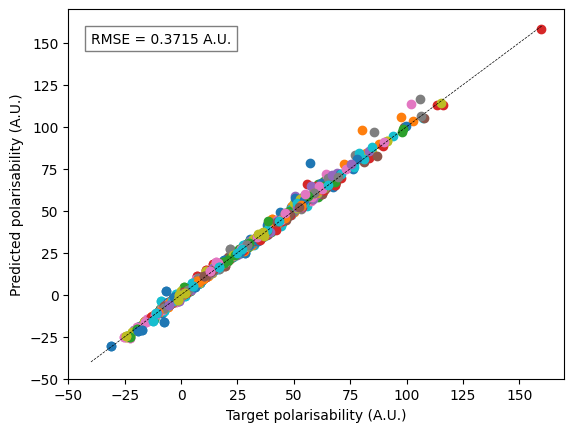

In [42]:
plt.figure()
for predicted, target in zip(polar_test.detach().numpy(), ref_polar[ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x,y)
    
plt.plot([-40,160], [-40,160], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target polarisability (A.U.)')
plt.ylabel('Predicted polarisability (A.U.)')
plt.text(-40, 150, f'RMSE = {(torch.sqrt(test_error_pol)).item():.4f} A.U.', fontsize = 10, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
plt.savefig("plot_polar/mse_polar_ridge.pdf", bbox_inches="tight")

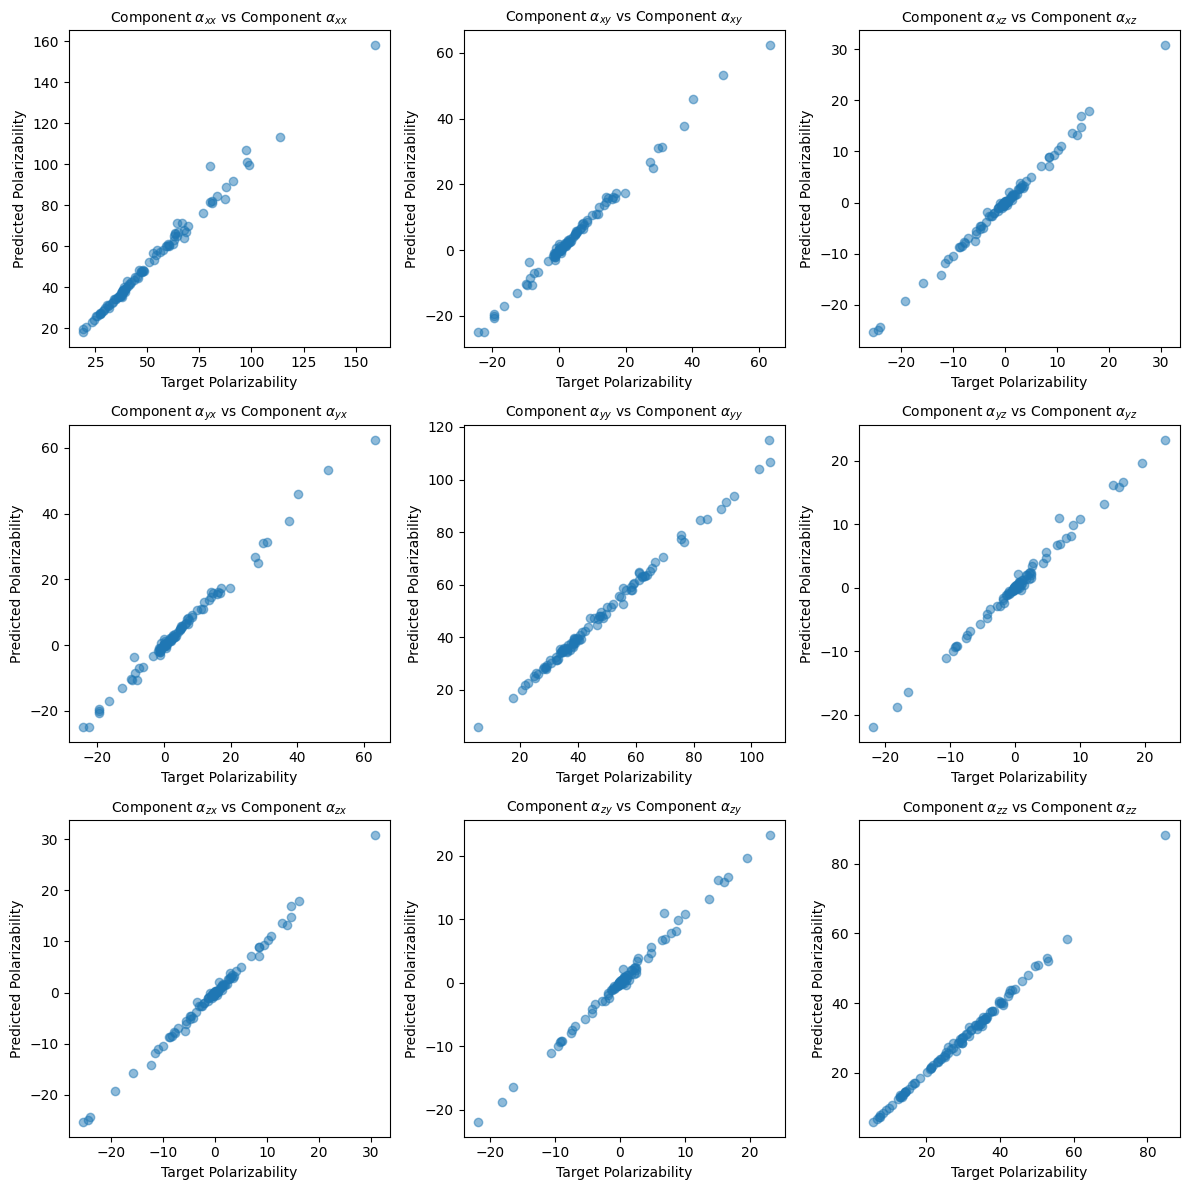

In [44]:
plt.figure()
fig, axs = plt.subplots(3,3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        l = [["xx", "xy", "xz"], ["yx", "yy", "yz"], ["zx", "zy", "zz"]]
        ax.scatter(ref_polar[ml_data.test_idx][:, i, j], polar_test.detach().numpy()[:, i, j], alpha=0.5)
        ax.set_xlabel('Target Polarizability')
        ax.set_ylabel('Predicted Polarizability')
        ax.set_title(fr'Component $\alpha_{{{l[i][j]}}}$ vs Component $\alpha_{{{l[i][j]}}}$', fontsize=10)

plt.tight_layout()
plt.savefig("plot_polar/mse_polar_comp.pdf", bbox_inches="tight")

## Indirect learning of dipoles via bacprop using `PySCFAD`

In [24]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"
import torch
from torch.autograd.functional import jacobian
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
from tqdm import tqdm

Using PyTorch backend.


In [26]:
with io.capture_output() as captured:
    all_mfs, fockvars = instantiate_mf(
        ml_data,
        fock_predictions=None,
        batch_indices=list(range(len(ml_data.structures))),
    )

In [26]:
from cmath import inf
best = inf
early_stop_criteria = 50

In [27]:
# Do this only if you want to start your indirect training from the Ridge fitted weights
train_pred = model.forward(ml_data.feat_train, return_type="tensor", batch_indices=ml_data.train_idx, ridge_fit=True)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=20, verbose=True
)

val_interval = 10
loss_fn = getattr(mlmetrics, "mse_qm7") 
losses = []
val_losses = []
early_stop_count = 0
nepochs = 1500

/home/suman/miniconda3/envs/qm7/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
iterator = tqdm(range(nepochs))

for epoch in iterator:
    model.train(True)
    train_loss = 0
    for data in train_dl:
        optimizer.zero_grad()
        idx = data["idx"]

        #forward pass
        pred = model(data["input"], return_type="tensor", batch_indices=[i.item() for i in idx])
        
        train_polar_pred, train_eva_pred = compute_batch_polarisability(ml_data, pred, batch_indices=idx, mfs=all_mfs)
        train_polar_ref = torch.from_numpy(ref_polar[idx].astype(np.float64))
        train_eva_ref = compute_eigvals(ml_data, [ml_data.target.tensor[i] for i in idx], idx)
        
        loss_polar = loss_fn(ml_data.train_frames, train_polar_pred, train_polar_ref)
        loss_eva = loss_fn(ml_data.train_frames, train_eva_pred, train_eva_ref)
        loss = loss_polar + loss_eva
        
        train_loss += loss.item()
        
        # backward pass
        loss.backward()
        optimizer.step()

    losses.append(train_loss)
    scheduler.step(train_loss)
    
    model.train(False)

    if epoch % val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            idx = data["idx"]
            val_pred = model(data["input"], return_type="tensor", batch_indices=[i.item() for i in idx])
            with io.capture_output() as captured:
            
                val_polar_pred, val_eva_pred = compute_batch_polarisability(ml_data, val_pred, batch_indices=idx, mfs=all_mfs)
                val_polar_ref = torch.from_numpy(ref_polar[idx].astype(np.float64))
                val_eva_ref = compute_eigvals(ml_data, [ml_data.target.tensor[i] for i in idx], idx)
                
            vloss_polar = loss_fn(ml_data.val_frames, val_polar_pred, val_polar_ref)
            vloss_eva = loss_fn(ml_data.val_frames, val_eva_pred, val_eva_ref)

            vloss = vloss_polar + vloss_eva
            val_loss += vloss.item()

        val_losses.append(val_loss)
        new_best = val_loss < best
        if new_best:
            best = val_loss
            torch.save(model.state_dict(), 'model_output_combined/best_model_dipole.pt')
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss}")

            print(f"Epoch {epoch} val loss {val_loss}")
            # Save last best model
            break
            
    if epoch % 100 == 0:
        torch.save(model.state_dict(), f'model_output_combined/model_epoch_{epoch}.pt')

    if epoch % 10 == 0:
        print("Epoch:", epoch, "train loss:", loss, "val loss:", vloss)
    
    if epoch % 1 == 0:
        iterator.set_postfix(train_loss = train_loss, Val_loss = val_loss)

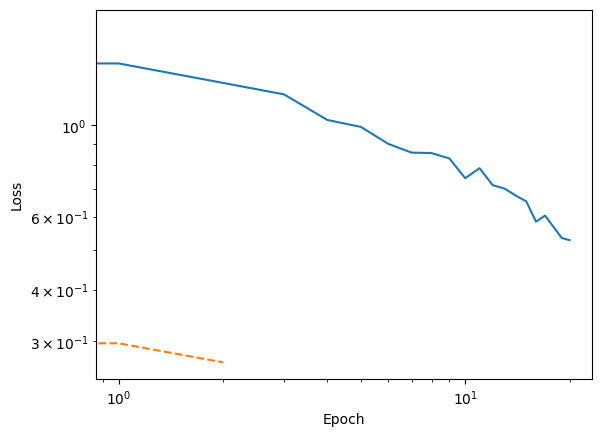

In [33]:
plt.figure()
plt.loglog(losses, label='training loss')
plt.loglog(val_losses, "--", label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("epoch_vs_loss.pdf", bbox_inches='tight')

In [ ]:
with io.capture_output() as captured:
    batch_indices = ml_data.train_idx
    train_fock_predictions = model.forward(
        ml_data.feat_train, return_type="tensor", batch_indices=batch_indices
    )
    train_polar_pred, _ = compute_batch_polarisability(
        ml_data, train_fock_predictions, batch_indices=batch_indices, mfs=all_mfs
    )

error = mlmetrics.mse_qm7(ml_data.train_frames,
    train_polar_pred, torch.from_numpy(ref_polar[batch_indices].astype(np.float64)))

print("Train MSE on polarisability", torch.sqrt(error))

In [27]:
with io.capture_output() as captured:
    batch_indices = ml_data.test_idx
    test_fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx,
    )
    test_dip_pred, test_eva_pred = compute_batch_dipole_moment(
        ml_data, test_fock_predictions, batch_indices=batch_indices, mfs=all_mfs
    )

error_dip = mlmetrics.mse_qm7(ml_data.test_frames,
    test_dip_pred, torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][batch_indices].astype(np.float64))
)
test_eva_ref = compute_eigvals(ml_data, [ml_data.target.tensor[i] for i in batch_indices], batch_indices)
error_eva = mlmetrics.mse_qm7(ml_data.test_frames, test_eva_pred, test_eva_ref)

In [28]:
print("Test RMSE on dipole from indirect learning {:.5f} A.U.".format(torch.sqrt(error_dip).item()))
print("Test RMSE on MO energies from indirect learning {:.5f} eV.".format(torch.sqrt(error_eva).item() * Hartree))

Test RMSE on dipole from indirect learning 0.01693 A.U.
Test RMSE on MO energies from indirect learning 0.31605 eV.


In [29]:
with io.capture_output() as captured:
    batch_indices = ml_data.test_idx
    test_fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx,
    )
    test_polar_pred, test_eva_pred = compute_batch_polarisability(
        ml_data, test_fock_predictions, batch_indices=batch_indices, mfs=all_mfs
    )

error_pol = mlmetrics.mse_qm7(ml_data.test_frames,
    test_polar_pred, torch.from_numpy(ref_polar[batch_indices].astype(np.float64))
)
test_eva_ref = compute_eigvals(ml_data, [ml_data.target.tensor[i] for i in batch_indices], batch_indices)
error_eva = mlmetrics.mse_qm7(ml_data.test_frames,test_eva_pred, test_eva_ref)

In [30]:
print("Test RMSE on polar from indirect learning {:.5f} A.U.".format(torch.sqrt(error_pol).item()))
print("Test RMSE on MO energies from indirect learning {:.5f} eV.".format(torch.sqrt(error_eva).item() * Hartree))

Test RMSE on polar from indirect learning 0.13766 A.U.
Test RMSE on MO energies from indirect learning 0.31605 eV.


In [32]:
import matplotlib.pyplot as plt

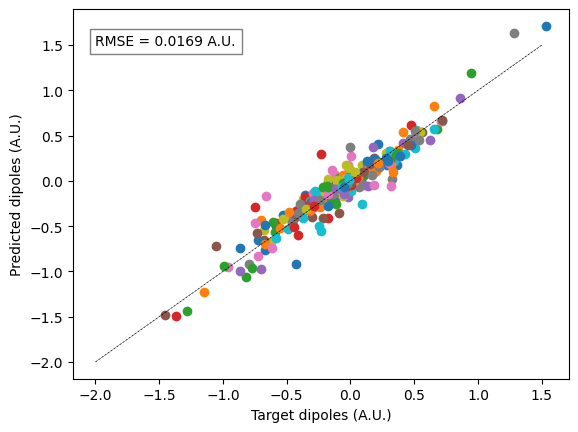

In [33]:
plt.figure()
for predicted, target in zip(test_dip_pred.detach().numpy(), ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x,y)
    
plt.plot([-2,1.5], [-2,1.5], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target dipoles (A.U.)')
plt.ylabel('Predicted dipoles (A.U.)')
plt.text(-2, 1.5, f'RMSE = {(torch.sqrt(error_dip)).item():.4f} A.U.', fontsize = 10, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
plt.savefig("plot_polar/mse_dipole_indirect.pdf", bbox_inches="tight")

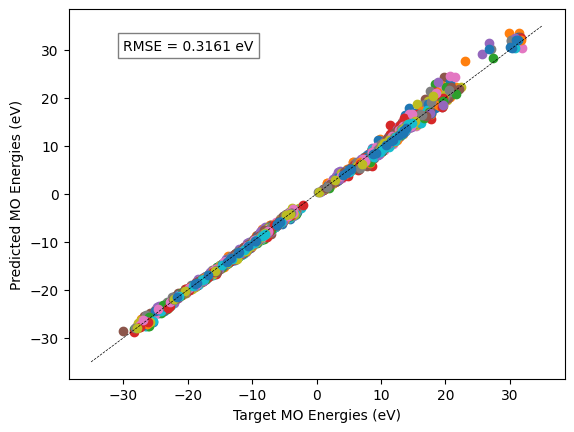

In [36]:
plt.figure()
for target, predicted in zip(test_eva_ref, test_eva_pred):
    x = target * Hartree
    y = predicted.detach().numpy() * Hartree
    
    x = x[x>-100]
    y = y[y>-100]
    plt.scatter(x,y)
    
plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.text(-30, 30, f'RMSE = {(torch.sqrt(error_eva)).item() * Hartree:.4f} eV', fontsize = 10, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
plt.savefig("plot_polar/mse_eva_indirect.pdf", bbox_inches="tight")


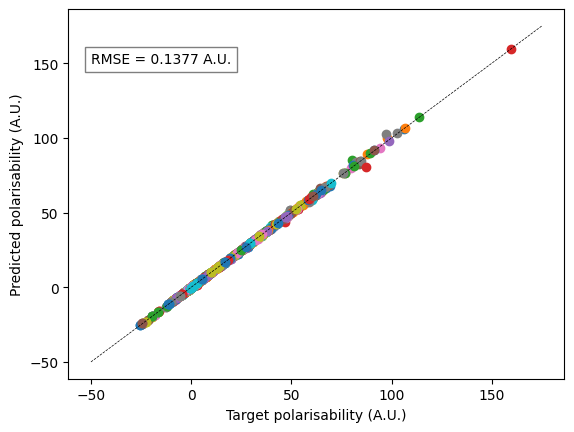

In [35]:
plt.figure()
for predicted, target in zip(test_polar_pred.detach().numpy(), ref_polar[ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x,y)
    
plt.plot([-50,175], [-50,175], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target polarisability (A.U.)')
plt.ylabel('Predicted polarisability (A.U.)')
plt.text(-50, 150, f'RMSE = {(torch.sqrt(error_pol)).item():.4f} A.U.', fontsize = 10, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
plt.savefig("plot_polar/mse_polar_indirect.pdf", bbox_inches="tight")